https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

https://www.kaggle.com/ligtfeather/semantic-segmentation-is-easy-with-pytorch/notebook

In [8]:
!wget "https://drive.google.com/uc?export=download&id=1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd&confirm=yes" -O "kaggle.json"
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download bulentsiyah/semantic-drone-dataset
!unzip semantic-drone-dataset.zip -d data

--2022-11-13 14:38:23--  https://drive.google.com/uc?export=download&id=1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd&confirm=yes
Resolving drive.google.com (drive.google.com)... 142.250.31.102, 142.250.31.138, 142.250.31.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.31.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/luhgdgdkpic1nnkfba665kee6kh695an/1668350250000/01749253850259784187/*/1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd?e=download&uuid=d562aae9-7676-4cb5-866d-a3b6c762c2a2 [following]
--2022-11-13 14:38:24--  https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/luhgdgdkpic1nnkfba665kee6kh695an/1668350250000/01749253850259784187/*/1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd?e=download&uuid=d562aae9-7676-4cb5-866d-a3b6c762c2a2
Resolving doc-0o-3c-docs.googleusercontent.com (doc-0o-3c-docs.googleusercontent.com)... 142.251.1

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.patches as mpatches

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 97 kB 3.8 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 376 kB 30.5 MB/s 


In [3]:
IMAGE_PATH = 'data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'data/dataset/semantic_drone_dataset/label_images_semantic/'

In [4]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [5]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.08, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.05, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  349
Val Size     :  19
Test Size    :  32


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


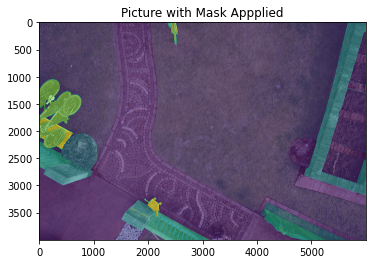

In [6]:
img = Image.open(IMAGE_PATH + df['id'][99] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][99] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [7]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [39]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Model

In [40]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [41]:
model = smp.DeepLabV3Plus('efficientnet-b1', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=256)

# Training

In [11]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [12]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        #training loop
        model.train()
        
        for i, data in enumerate(tqdm(train_loader)):
            
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        #validation loop
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                #reshape to 9 patches from single image, delete batch size
                image_tiles, mask_tiles = data
                
                image = image_tiles.to(device); mask = mask_tiles.to(device);
                output = model(image)
                #evaluation metrics
                val_iou_score +=  mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                #loss
                loss = criterion(output, mask)                                  
                test_loss += loss.item()
        
        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))


        if min_loss > (test_loss/len(val_loader)):
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
            min_loss = (test_loss/len(val_loader))          

        if (test_loss/len(val_loader)) > min_loss:
            min_loss = (test_loss/len(val_loader))
            print('Loss Not Decrease')
        
        #iou
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))
        train_acc.append(accuracy/len(train_loader))
        val_acc.append(test_accuracy/ len(val_loader))
        print("Epoch:{}/{}..".format(e+1, epochs),
                "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [57]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model, 'Unet-Mobilenet.pt')

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.346 
Epoch:1/15.. Train Loss: 0.323.. Val Loss: 0.346.. Train mIoU:0.536.. Val mIoU: 0.547.. Train Acc:0.898.. Val Acc:0.895.. Time: 5.03m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:2/15.. Train Loss: 0.340.. Val Loss: 0.395.. Train mIoU:0.530.. Val mIoU: 0.501.. Train Acc:0.892.. Val Acc:0.882.. Time: 5.07m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:3/15.. Train Loss: 0.491.. Val Loss: 0.670.. Train mIoU:0.472.. Val mIoU: 0.392.. Train Acc:0.845.. Val Acc:0.790.. Time: 5.04m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.670 >> 0.481 
Epoch:4/15.. Train Loss: 0.536.. Val Loss: 0.481.. Train mIoU:0.437.. Val mIoU: 0.441.. Train Acc:0.831.. Val Acc:0.840.. Time: 5.06m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:5/15.. Train Loss: 0.523.. Val Loss: 1.175.. Train mIoU:0.457.. Val mIoU: 0.324.. Train Acc:0.835.. Val Acc:0.660.. Time: 5.07m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 1.175 >> 0.412 
Epoch:6/15.. Train Loss: 0.478.. Val Loss: 0.412.. Train mIoU:0.464.. Val mIoU: 0.468.. Train Acc:0.849.. Val Acc:0.873.. Time: 5.07m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.353 
Epoch:7/15.. Train Loss: 0.369.. Val Loss: 0.353.. Train mIoU:0.511.. Val mIoU: 0.468.. Train Acc:0.882.. Val Acc:0.889.. Time: 5.06m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:8/15.. Train Loss: 0.392.. Val Loss: 0.381.. Train mIoU:0.507.. Val mIoU: 0.526.. Train Acc:0.875.. Val Acc:0.884.. Time: 5.05m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:9/15.. Train Loss: 0.321.. Val Loss: 0.389.. Train mIoU:0.539.. Val mIoU: 0.521.. Train Acc:0.896.. Val Acc:0.884.. Time: 5.04m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.389 >> 0.332 
Epoch:10/15.. Train Loss: 0.341.. Val Loss: 0.332.. Train mIoU:0.550.. Val mIoU: 0.553.. Train Acc:0.895.. Val Acc:0.890.. Time: 5.03m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.332 >> 0.316 
Epoch:11/15.. Train Loss: 0.293.. Val Loss: 0.316.. Train mIoU:0.557.. Val mIoU: 0.550.. Train Acc:0.904.. Val Acc:0.898.. Time: 5.06m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:12/15.. Train Loss: 0.285.. Val Loss: 0.320.. Train mIoU:0.567.. Val mIoU: 0.538.. Train Acc:0.907.. Val Acc:0.899.. Time: 4.96m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.320 >> 0.306 
Epoch:13/15.. Train Loss: 0.266.. Val Loss: 0.306.. Train mIoU:0.581.. Val mIoU: 0.562.. Train Acc:0.913.. Val Acc:0.903.. Time: 4.98m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:14/15.. Train Loss: 0.269.. Val Loss: 0.347.. Train mIoU:0.580.. Val mIoU: 0.537.. Train Acc:0.912.. Val Acc:0.892.. Time: 4.99m


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss Decreasing.. 0.347 >> 0.287 
Epoch:15/15.. Train Loss: 0.246.. Val Loss: 0.287.. Train mIoU:0.591.. Val mIoU: 0.555.. Train Acc:0.919.. Val Acc:0.911.. Time: 4.96m
Total time: 75.49 m


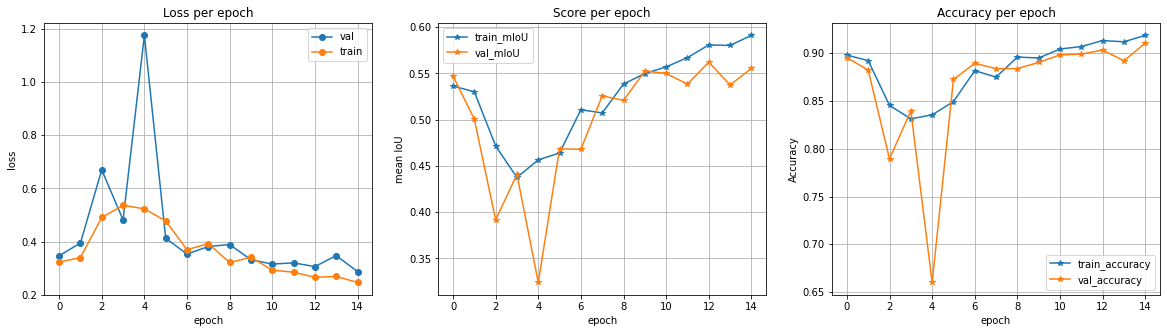

In [58]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plot_loss(history)
plt.subplot(1,3,2); plot_score(history)
plt.subplot(1,3,3); plot_acc(history)
plt.show()

# Evaluation

In [59]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [60]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [61]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

mob_miou = miou_score(model, test_set)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/32 [00:00<?, ?it/s]

Test Set mIoU 0.5816868497599625


In [62]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/32 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.9178382379037362


In [63]:
def plot_seg_mask(mask, ax, title, labels):
    im = ax.imshow(mask)
    ax.set_title(title)
    ax.set_axis_off()

    label = labels.loc[mask.unique().tolist()].name.to_list()
    values = np.unique(mask.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=lab) for i,lab in enumerate(label) ]

    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def display_results(i, test_set, model):
    image1, mask1 = test_set[i]
    pred_mask1, score1 = predict_image_mask_miou(model, image1, mask1)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(image1)
    ax1.set_title('Picture')

    plot_seg_mask(mask1, ax2, "Ground truth", label)
    plot_seg_mask(pred_mask1, ax3, 'UNet-MobileNet | mIoU {:.3f}'.format(score1), label)

    fig.tight_layout()

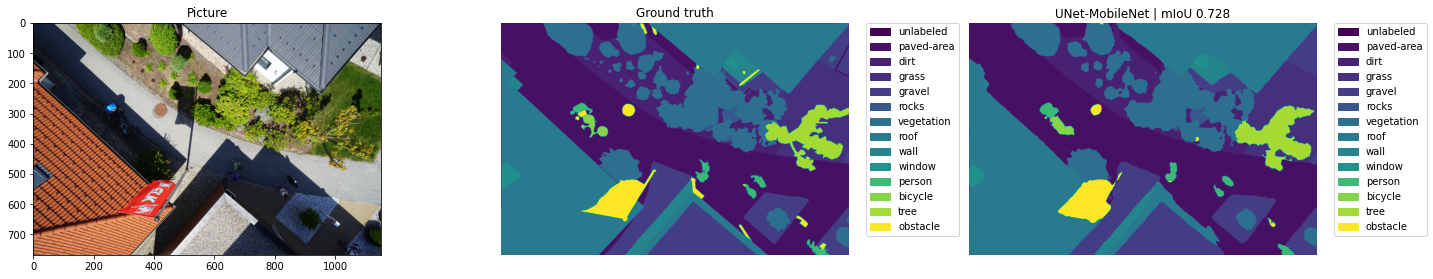

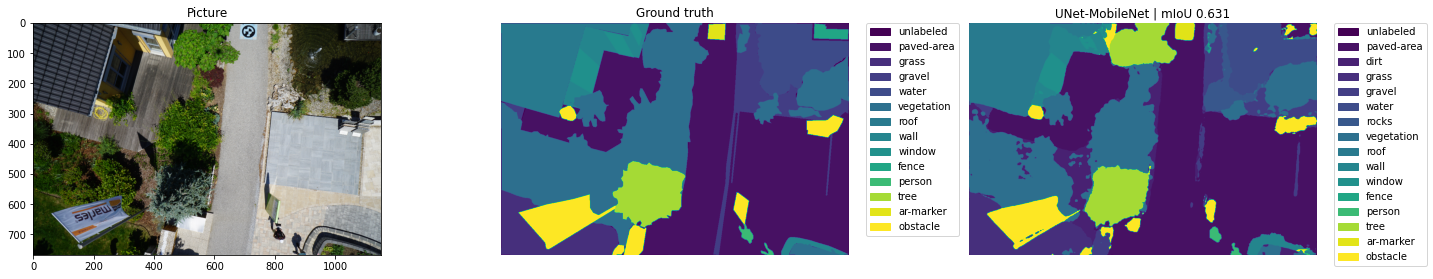

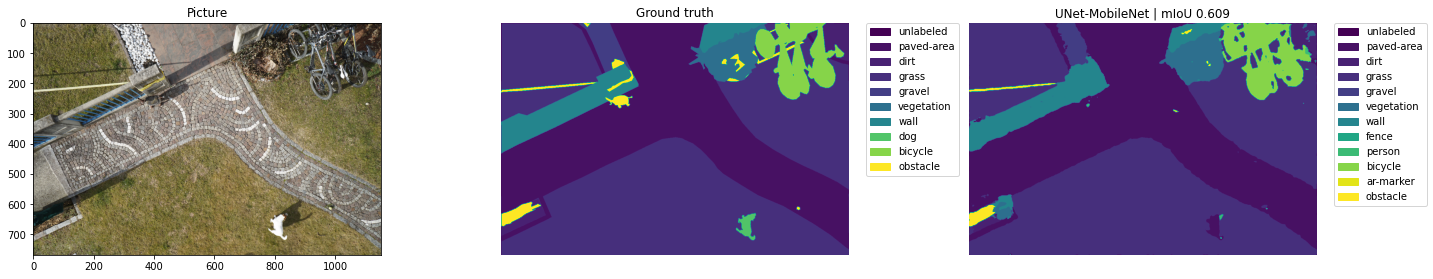

In [64]:
label = pd.read_csv("data/class_dict_seg.csv")

display_results(2, test_set, model)
display_results(4, test_set, model)
display_results(6, test_set, model)